Initial shape: (2000, 18)
Missing values:
 Remoteness_1to5                  0
Area_Risk_Level                  0
Num_People                       0
Time_of_Visit                    0
Mode_of_Travel                   0
Age                              0
Gender                           0
Purpose                          0
Inside_Restricted_Zone           0
Weather                          0
Connectivity                     0
Distance_to_Safe_Zone_km         0
Distance_to_High_Risk_Zone_km    0
Risk_Score                       0
Safety_Score                     0
dtype: int64
Accuracy: 0.995

Confusion Matrix:
 [[ 97   1   0   0]
 [  0  68   0   1]
 [  0   0 101   0]
 [  0   0   0 132]]

Classification Report:
               precision    recall  f1-score   support

     Extreme       1.00      0.99      0.99        98
        High       0.99      0.99      0.99        69
         Low       1.00      1.00      1.00       101
      Medium       0.99      1.00      1.00       132

    accur

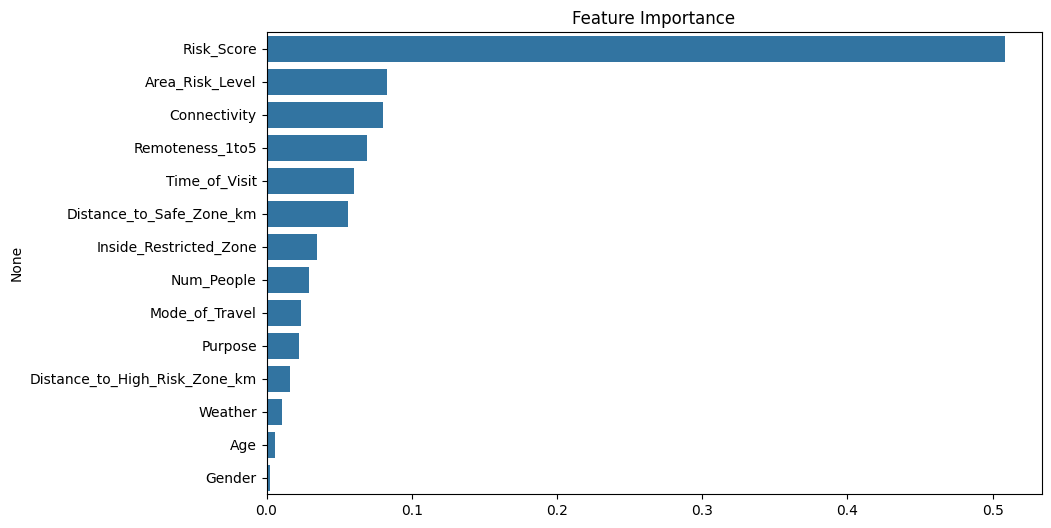


Prediction for Shillong example: Extreme
Class probabilities: {'Extreme': np.float64(0.975), 'High': np.float64(0.025), 'Low': np.float64(0.0), 'Medium': np.float64(0.0)}


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────────────────────────
# 1) Load dataset
# ───────────────────────────────
df = pd.read_csv("/content/sample_data/tourist_safety_dataset_realistic_v2 (4).csv")
print("Initial shape:", df.shape)

# ───────────────────────────────
# 2) Data Cleaning
# ───────────────────────────────
df_clean = df.drop(columns=["Destination", "State", "Terrain"])  # remove identifiers

# Check for missing values
print("Missing values:\n", df_clean.isnull().sum())

# ───────────────────────────────
# 3) Encode categorical variables
# ───────────────────────────────
categorical_cols = ["Area_Risk_Level","Time_of_Visit","Mode_of_Travel","Age",
                    "Gender","Purpose","Weather","Connectivity"]

le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    le_dict[col] = le  # store encoders

# Encode target variable
target_le = LabelEncoder()
df_clean["Safety_Score"] = target_le.fit_transform(df_clean["Safety_Score"])

# ───────────────────────────────
# 4) Split into features and target
# ───────────────────────────────
X = df_clean.drop(columns=["Safety_Score"])
y = df_clean["Safety_Score"]

# ───────────────────────────────
# 5) Train-test split
# ───────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features
scaler = StandardScaler()
num_cols = ["Remoteness_1to5", "Num_People", "Inside_Restricted_Zone",
            "Distance_to_Safe_Zone_km", "Distance_to_High_Risk_Zone_km", "Risk_Score"]
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# ───────────────────────────────
# 6) Train Random Forest Classifier
# ───────────────────────────────
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# ───────────────────────────────
# 7) Predictions & Evaluation
# ───────────────────────────────
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_le.classes_))

# ───────────────────────────────
# 8) Feature importance plot
# ───────────────────────────────
feat_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance")
plt.show()

# ───────────────────────────────
# 9) Predict for one example (Shillong case)
# ───────────────────────────────
sample_data = pd.DataFrame([{
    "Destination": "Sandakphu",
    "State": "West Bengal",
    "Terrain": "Trek Peak",
    "Remoteness_1to5": 4,
    "Area_Risk_Level": "High",
    "Num_People": 4,
    "Time_of_Visit": "Day",
    "Mode_of_Travel": "Cab",
    "Age": "26-35",
    "Gender": "Female",
    "Purpose": "Pilgrimage",
    "Inside_Restricted_Zone": 0,
    "Weather": "Fog",
    "Connectivity": "Poor",
    "Distance_to_Safe_Zone_km": 10.07,
    "Distance_to_High_Risk_Zone_km": 1.28,
    "Risk_Score": 0.772,

}])




# Drop identifiers (Destination, State, Terrain)
sample_clean = sample_data.drop(columns=["Destination","State","Terrain"])

# Encode categorical values using stored label encoders
for col, le in le_dict.items():
    if col in sample_clean:
        sample_clean[col] = le.transform(sample_clean[col])

# Scale numeric values
sample_clean[num_cols] = scaler.transform(sample_clean[num_cols])

# Predict
sample_pred = clf.predict(sample_clean)
predicted_label = target_le.inverse_transform(sample_pred)

print("\nPrediction for Shillong example:", predicted_label[0])

# (Optional) Probability distribution across classes
sample_probs = clf.predict_proba(sample_clean)
print("Class probabilities:", dict(zip(target_le.classes_, sample_probs[0])))
